## Load Data

In [ ]:
import pandas as pd
import numpy as np
import statistics

In [ ]:
filename = 'CL_sentence_v3.xlsx'
#filename = '/CL_sentences.xlsx'
data = pd.read_excel(filename, header=0)
data.head()

,item,condition,subject,VC,CL,BEI,embedded_N,RC_verb,DE,target_N,has_BEI,is_match,search_noun
0,1,1,小美,移开了,那只,被,足球,打碎,的,花瓶,1,1,足球，球
1,1,2,小美,移开了,那只,NaN,足球,打碎,的,花瓶,0,1,足球，球
2,1,3,小美,移开了,那扇,被,足球,打碎,的,窗户,1,0,足球，球
3,1,4,小美,移开了,那扇,NaN,足球,打碎,的,窗户,0,0,足球，球
4,2,1,小美,扔了,那只,被,狗,咬坏,的,球,1,1,狗


In [ ]:
# fill NaN in BEI column with nothing to form the 
df = data.fillna("")
cols = ['subject', 'VC', 'CL', 'BEI', 'embedded_N']
df['sent'] = df[cols].apply(lambda x: "".join(x), axis=1)
df.head()

,item,condition,subject,VC,CL,BEI,embedded_N,RC_verb,DE,target_N,has_BEI,is_match,search_noun,sent
0,1,1,小美,移开了,那只,被,足球,打碎,的,花瓶,1,1,足球，球,小美移开了那只被足球
1,1,2,小美,移开了,那只,,足球,打碎,的,花瓶,0,1,足球，球,小美移开了那只足球
2,1,3,小美,移开了,那扇,被,足球,打碎,的,窗户,1,0,足球，球,小美移开了那扇被足球
3,1,4,小美,移开了,那扇,,足球,打碎,的,窗户,0,0,足球，球,小美移开了那扇足球
4,2,1,小美,扔了,那只,被,狗,咬坏,的,球,1,1,狗,小美扔了那只被狗


## Load Language Models

In [ ]:
!pip install transformers
!pip install -U ckip-transformers  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import pipeline
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
# roberta base LM for word prediction
unmasker = pipeline('fill-mask', model='xlm-roberta-base') # https://huggingface.co/xlm-roberta-base
# bert base POS tagger
pos_driver = CkipPosTagger(model="bert-base")  # https://github.com/ckiplab/ckip-transformers

In [ ]:
def get_predicts(sentence, k=100):
  '''
  input a sentence and output a dataframe with top k predictions on <mask> and 
  the Part-of-Speech tags of it
  '''

  # predict probabilities
  sent = sentence + '<mask>'
  pred_n = unmasker(sent, top_k=k)

  # store results in dataframe
  scores, words = [], []
  for p in pred_n:
    scores.append(p['score'])
    words.append(p['token_str'])

  df = pd.DataFrame({'token': words, 'score': scores})

  
  # obtain the POS tags of the predicted results
  df['POS'] = pos_driver(df['token'])
  df['POS_n'] = 1
  #. change punctuations to PUNC label
  punctuations = ['PERIODCATEGORY', 'EXCLAMATIONCATEGORY', 'QUESTIONCATEGORY', 'COMMACATEGORY', 'PARENTHESISCATEGORY']
  for i in range(len(df['POS'])):
    if df['POS'][i] and df['POS'][i][0] in punctuations:
      df['POS'][i] = ['PUNC']
    # add POS count
    df['POS_n'][i] = len(df['POS'][i])

  return df

In [ ]:
# an example of results (predicted probabilities of top 100 words and their POS tags) obtained by the function
sent = "晓明扔掉了那颗被小狗"
results = get_predicts(sent)
results

Inference: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it]
<ipython-input-34-8aee3a96689f>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['POS_n'][i] = len(df['POS'][i])
<ipython-input-34-8aee3a96689f>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['POS'][i] = ['PUNC']


,token,score,POS,POS_n
0,吃了,0.306497,"[VC, Di]",2
1,咬,0.110972,[VC],1
2,</s>,0.070685,"[FW, FW, FW, FW]",4
3,吃,0.034744,[VC],1
4,的,0.030292,[DE],1
...,...,...,...,...
95,碎,0.000879,[VH],1
96,皮,0.000876,[Na],1
97,的名字,0.000869,"[DE, Na, Na]",3
98,的想法,0.000866,"[DE, Na, Na]",3


In [ ]:
def get_statistics(data,target):
  '''get the list of predicted words with their predicted probabilities that has POS tagged as target value (e.g. VC, Na)'''
  lst = []
  for i in range(len(data)):
    if target in data['POS'][i]:
      # prob += data['score'][i]
      lst.append((i, data['token'][i], data['score'][i]))
  return lst

In [ ]:
import statistics
def get_results(df,target='VC'):
  '''get the summary statistics of predicted probabilities for words that has POS tagged as target value (e.g. VC, Na)'''
  results = pd.DataFrame(columns=['item', 'condition','has_BEI','is_match',
                                'total_VC_prob','mean_prob','median_prob',
                                'min_prob','min_word','max_prob','max_word',
                                'max_rank','count_n'])

  for idx, row in df.iterrows():
    
      print(idx) #track process
      data = get_predicts(row['sent'])
      l = get_statistics(data,target)
      
      probs = [i[2] for i in l]
      
      if len(probs) == 0:
        results.loc[idx] = [row['item'], row['condition'], row['has_BEI'], row['is_match'], 
                            0, 0, 0, 0, 0, 0,
                            0, 0, 0]
      else:
        prob_sum = sum(probs)  # sum of probabilities
        prob_mean = sum(probs) / len(probs)  # mean
        prob_median = statistics.median(probs)  # median
        min_prob, max_prob = min(l, key=lambda x:x[2]), max(l, key=lambda x:x[2]) # min & max
        max_rank = min(l, key=lambda x:x[0]) # highest in rank
        count_n = len(probs)  # number of predictions of VC
        results.loc[idx] = [row['item'], row['condition'], row['has_BEI'], row['is_match'], 
                            prob_sum, prob_mean, prob_median, min_prob[2], min_prob[1],
                            max_prob[2], max_prob[1], max_rank[0], count_n]

  return results

In [ ]:
# run the experiment result
results_VC = get_results(df, target='VC')
results_VC

0


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]
<ipython-input-34-8aee3a96689f>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['POS_n'][i] = len(df['POS'][i])
<ipython-input-34-8aee3a96689f>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['POS'][i] = ['PUNC']


1


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


2


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


3


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


4


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


5


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.94s/it]


6


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


7


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.78s/it]


8


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


9


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]


10


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


11


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


12


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


13


Inference: 100%|██████████| 1/1 [00:07<00:00,  8.00s/it]


14


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


15


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.61s/it]


16


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


17


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


18


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


19


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


20


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]


21


Inference: 100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


22


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


23


Inference: 100%|██████████| 1/1 [00:06<00:00,  6.85s/it]


24


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


25


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.91s/it]


26


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


27


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.92s/it]


28


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.57s/it]


29


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.22s/it]


30


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


31


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.64s/it]


32


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.79s/it]


33


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.76s/it]


34


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


35


Inference: 100%|██████████| 1/1 [00:06<00:00,  6.88s/it]


36


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


37


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.40s/it]


38


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


39


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


40


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


41


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


42


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]


43


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


44


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


45


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.37s/it]


46


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


47


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


48


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


49


Inference: 100%|██████████| 1/1 [00:07<00:00,  7.30s/it]


50


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


51


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


52


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


53


Inference: 100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


54


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


55


Inference: 100%|██████████| 1/1 [00:06<00:00,  6.36s/it]


56


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


57


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it]


58


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


59


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.76s/it]


60


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


61


Inference: 100%|██████████| 1/1 [00:07<00:00,  7.45s/it]


62


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


63


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.40s/it]


64


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


65


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.34s/it]


66


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


67


Inference: 100%|██████████| 1/1 [00:06<00:00,  6.32s/it]


68


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it]


69


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.93s/it]


70


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


71


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.15s/it]


72


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


73


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


74


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


75


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.41s/it]


76


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


77


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.76s/it]


78


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


79


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


80


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


81


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.88s/it]


82


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


83


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.86s/it]


84


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.20s/it]


85


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


86


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


87


Inference: 100%|██████████| 1/1 [00:06<00:00,  6.43s/it]


88


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


89


Inference: 100%|██████████| 1/1 [00:06<00:00,  6.41s/it]


90


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.29s/it]


91


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.72s/it]


92


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it]


93


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it]


94


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


95


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


96


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


97


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


98


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


99


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]


100


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


101


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.58s/it]


102


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


103


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.25s/it]


104


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


105


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


106


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


107


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


108


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


109


Inference: 100%|██████████| 1/1 [00:06<00:00,  6.60s/it]


110


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


111


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.92s/it]


112


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


113


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


114


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


115


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


116


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


117


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


118


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


119


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.92s/it]


120


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


121


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


122


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


123


Inference: 100%|██████████| 1/1 [00:07<00:00,  7.42s/it]


124


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


125


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


126


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


127


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.10s/it]


128


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


129


Inference: 100%|██████████| 1/1 [00:08<00:00,  8.30s/it]


130


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


131


Inference: 100%|██████████| 1/1 [00:06<00:00,  6.24s/it]


132


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


133


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


134


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


135


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


136


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.31s/it]


137


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.92s/it]


138


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.34s/it]


139


Inference: 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]


140


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


141


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.57s/it]


142


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.52s/it]


143


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.01s/it]


144


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


145


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.42s/it]


146


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


147


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


148


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.32s/it]


149


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.41s/it]


150


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


151


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.63s/it]


152


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


153


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.72s/it]


154


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.55s/it]


155


Inference: 100%|██████████| 1/1 [00:04<00:00,  4.93s/it]


156


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


157


Inference: 100%|██████████| 1/1 [00:06<00:00,  6.31s/it]


158


Inference: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


159


Inference: 100%|██████████| 1/1 [00:05<00:00,  5.11s/it]


,item,condition,has_BEI,is_match,total_VC_prob,mean_prob,median_prob,min_prob,min_word,max_prob,max_word,max_rank,count_n
0,1,1,1,1,0.104493,0.004750,0.002030,0.001063,撞,0.049660,踢,3,22
1,1,2,0,1,0.009107,0.001821,0.001167,0.000938,展,0.003503,踢,37,5
2,1,3,1,0,0.033382,0.003035,0.001344,0.000763,吹,0.014372,踢,9,11
3,1,4,0,0,0.001032,0.000344,0.000236,0.000130,踢,0.000665,架,30,3
4,2,1,1,1,0.315907,0.009872,0.001561,0.000780,跟踪,0.176515,咬,0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,39,4,0,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,0,0
156,40,1,1,1,0.153845,0.003945,0.001443,0.000629,操,0.077624,咬,2,39
157,40,2,0,1,0.000389,0.000389,0.000389,0.000389,的衣服,0.000389,的衣服,58,1
158,40,3,1,0,0.109241,0.004202,0.001345,0.000728,踢,0.047583,咬,5,26


In [ ]:
# save results
results_VC.to_csv('results_VC.csv',encoding="utf_8_sig")

In [ ]:
#results_NA = get_results(df, target='Na')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='total_VC_prob', ylabel='Count'>

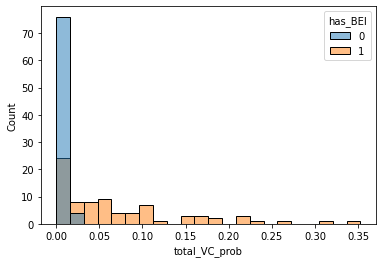

In [ ]:
# visualizations
sns.histplot(data=results_VC, x="total_VC_prob", hue="has_BEI")

<AxesSubplot:xlabel='has_BEI', ylabel='total_VC_prob'>

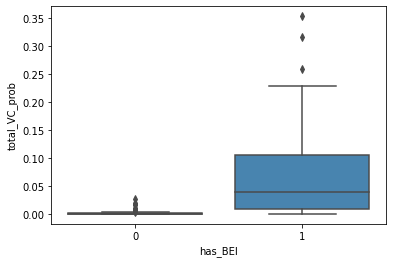

In [ ]:
sns.boxplot(x='has_BEI',
            y='total_VC_prob',
            data=results_VC,
            orient='v',
            palette='Blues'
           )

<AxesSubplot:xlabel='total_VC_prob', ylabel='Count'>

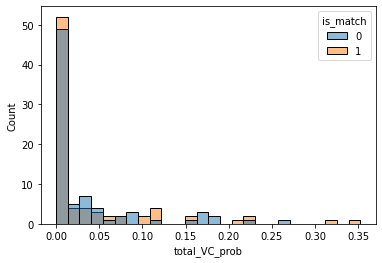

In [ ]:
sns.histplot(data=results_VC, x="total_VC_prob", hue="is_match")

<AxesSubplot:xlabel='is_match', ylabel='total_VC_prob'>

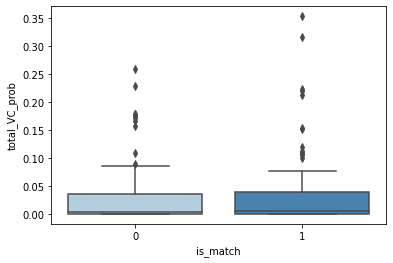

In [ ]:
sns.boxplot(x='is_match',
            y='total_VC_prob',
            data=results_VC,
            orient='v',
            palette='Blues'
           )

In [ ]:
sent = '一扇窗户被砖头打碎了。小美移开了那扇'
unmasker(sent+'<mask>', top_k=20)

[{'score': 0.5291669964790344,
  'token': 30,
  'token_str': '。',
  'sequence': '一扇窗户被砖头打碎了。小美移开了那扇。'},
 {'score': 0.2620716094970703,
  'token': 230615,
  'token_str': '窗户',
  'sequence': '一扇窗户被砖头打碎了。小美移开了那扇窗户'},
 {'score': 0.042259883135557175,
  'token': 4,
  'token_str': ',',
  'sequence': '一扇窗户被砖头打碎了。小美移开了那扇,'},
 {'score': 0.0368005745112896,
  'token': 31271,
  'token_str': '窗',
  'sequence': '一扇窗户被砖头打碎了。小美移开了那扇窗'},
 {'score': 0.02050136588513851,
  'token': 6349,
  'token_str': '门',
  'sequence': '一扇窗户被砖头打碎了。小美移开了那扇门'},
 {'score': 0.017226384952664375,
  'token': 5,
  'token_str': '.',
  'sequence': '一扇窗户被砖头打碎了。小美移开了那扇.'},
 {'score': 0.015305806882679462,
  'token': 2,
  'token_str': '</s>',
  'sequence': '一扇窗户被砖头打碎了。小美移开了那扇'},
 {'score': 0.010995295830070972,
  'token': 27,
  'token_str': '...',
  'sequence': '一扇窗户被砖头打碎了。小美移开了那扇...'},
 {'score': 0.008614880032837391,
  'token': 38,
  'token_str': '!',
  'sequence': '一扇窗户被砖头打碎了。小美移开了那扇!'},
 {'score': 0.00701333861798048,
  'toke

In [ ]:
results_VC_df = pd.read_csv('/content/results_VC (1).csv')

In [ ]:
results_VC_df

,Unnamed: 0,item,condition,has_BEI,is_match,total_VC_prob,mean_prob,median_prob,min_prob,min_word,max_prob,max_word,max_rank,count_n
0,0,1,1,1,1,0.104493,0.004750,0.002030,0.001063,撞,0.049660,踢,3,22
1,1,1,2,0,1,0.009107,0.001821,0.001167,0.000938,展,0.003503,踢,37,5
2,2,1,3,1,0,0.033382,0.003035,0.001344,0.000763,吹,0.014372,踢,9,11
3,3,1,4,0,0,0.001032,0.000344,0.000236,0.000130,踢,0.000665,架,30,3
4,4,2,1,1,1,0.315907,0.009872,0.001561,0.000780,跟踪,0.176515,咬,0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,155,39,4,0,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,0,0
156,156,40,1,1,1,0.153845,0.003945,0.001443,0.000629,操,0.077624,咬,2,39
157,157,40,2,0,1,0.000389,0.000389,0.000389,0.000389,的衣服,0.000389,的衣服,58,1
158,158,40,3,1,0,0.109241,0.004202,0.001345,0.000728,踢,0.047583,咬,5,26


In [ ]:
# calculate surprisal
results_VC_df['surprisal'] = -np.log2(results_VC_df['total_VC_prob'])

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# set infinite surprisal as 15
results_VC_df.loc[results_VC_df['surprisal']== float('inf'), "surprisal"] = 15

<AxesSubplot:xlabel='surprisal', ylabel='Count'>

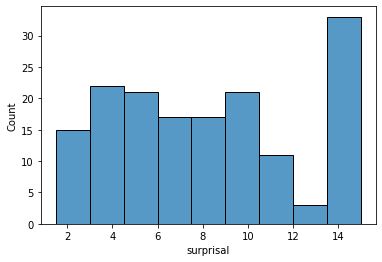

In [ ]:
sns.histplot(data=results_VC_df, x="surprisal")

In [ ]:
results_VC_df['surprisal'].describe()

count    160.000000
mean       8.371994
std        4.290836
min        1.503984
25%        4.704214
50%        7.797993
75%       11.264819
max       15.000000
Name: surprisal, dtype: float64

In [ ]:
results_VC_df = pd.read_csv('/content/results_VC (1).csv')

In [ ]:
# run statistical testing
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

results_VC_df['log_prob'] = np.log(results_VC_df['total_VC_prob'])

# model = smf.mixedlm(formula='log_prob ~ has_BEI + is_match + has_BEI:is_match', 
#                     data=results_VC_df,
#                     groups=results_VC_df["item"]).fit()

model = smf.mixedlm(formula='total_VC_prob ~ has_BEI + is_match + has_BEI:is_match', 
                    data=results_VC_df,
                    groups=results_VC_df["item"]).fit()

print_model = model.summary()
print(print_model)

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: total_VC_prob
No. Observations: 160     Method:             REML         
No. Groups:       40      Scale:              0.0023       
Min. group size:  4       Log-Likelihood:     227.1727     
Max. group size:  4       Converged:          Yes          
Mean group size:  4.0                                      
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.002    0.009  0.251 0.802 -0.015  0.020
has_BEI           0.064    0.011  5.910 0.000  0.043  0.085
is_match         -0.000    0.011 -0.001 0.999 -0.021  0.021
has_BEI:is_match  0.008    0.015  0.517 0.605 -0.022  0.038
Group Var         0.001    0.008                           



/usr/local/lib/python3.8/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [1]:
# sns.regplot(data=results_VC, y='total_VC_prob')